<a href="https://colab.research.google.com/github/eunzzae/dacon_weblog/blob/main/Dacon_%EC%9B%B9%EB%A1%9C%EA%B7%B8_%EC%A1%B0%ED%9A%8C%EC%88%98%EC%98%88%EC%B8%A1_EDA(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

웹로그 조회수예측



## 01. 데이터 소개 및 분석프로세스 수립

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

In [3]:
############################################## 00. 필요한 파이썬 라이브러리 불러오기 #####################################################
import pandas as pd
import numpy as np
import seaborn as sns
import missingno

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

## 02. 데이터 준비를 위한 EDA 및 전처리
---
[EDA 체크리스트]
1. 문제정의
2. 중복된 항목
3. 데이터 타입
4. 결측치 처리
5. 이상치 처리
6. 변수 간 상관성
---

### 0. 데이터 불러오기



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
base_path = '/content/drive/MyDrive/Colab Notebooks/data/dacon_weblog/'
train = pd.read_csv(base_path + 'train.csv')
test = pd.read_csv(base_path + 'test.csv')
sample_submission = pd.read_csv(base_path + 'sample_submission.csv')

sessionID : 세션 ID

userID : 사용자 ID

TARGET : 세션에서 발생한 총 조회수

browser : 사용된 브라우저

OS : 사용된 기기의 운영체제

device : 사용된 기기

new : 첫 방문 여부 (0: 첫 방문 아님, 1: 첫 방문)

quality : 세션의 질 (거래 성사를 기준으로 측정된 값, 범위: 1~100)

duration : 총 세션 시간 (단위: 초)

bounced : 이탈 여부 (0: 이탈하지 않음, 1: 이탈함)

transaction : 세션 내에서 발생의 거래의 수

transaction_revenue : 총 거래 수익

continent : 세션이 발생한 대륙

subcontinent : 세션이 발생한 하위 대륙

country : 세션이 발생한 국가

traffic_source : 트래픽이 발생한 소스

traffic_medium : 트래픽 소스의 매체

keyword : 트래픽 소스의 키워드, 일반적으로 traffic_medium이 organic, cpc인 경우에 설정

referral_path : traffic_medium이 referral인 경우 설정되는 경로



### 1. 문제정의
> 고객의 웹로그를 분석하여 조회수를 예측하려고 한다.

> 간략하게 데이터 살피기

In [6]:
# 데이터의 모양 알아보기
print(train.shape)

(252289, 19)


In [7]:
# 데이터의 15개 행 데이터만 확인하기
print(train.head(15))

         sessionID       userID  TARGET           browser         OS   device  \
0   SESSION_000000  USER_000000    17.0            Chrome  Macintosh  desktop   
1   SESSION_000001  USER_000001     3.0            Chrome    Windows  desktop   
2   SESSION_000002  USER_000002     1.0  Samsung Internet    Android   mobile   
3   SESSION_000003  USER_000003     1.0            Chrome  Macintosh  desktop   
4   SESSION_000004  USER_000004     1.0            Chrome        iOS   mobile   
5   SESSION_000005  USER_000005     1.0            Chrome    Android   tablet   
6   SESSION_000006  USER_000006     1.0            Chrome    Windows  desktop   
7   SESSION_000007  USER_000007     5.0            Chrome  Macintosh  desktop   
8   SESSION_000008  USER_000008     5.0           Firefox      Linux  desktop   
9   SESSION_000009  USER_000009     3.0            Chrome  Macintosh  desktop   
10  SESSION_000010  USER_000010     6.0            Chrome    Windows  desktop   
11  SESSION_000011  USER_000

*   Target과 관계없는 것은 없는가?
*   컬럼 중 의미가 이해가지 않는 것은 없는가?
*   약어나 전문 용어로 되어 있는 것은 없는가?



In [8]:
train[train['userID']=='USER_000005']

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
5,SESSION_000005,USER_000005,1.0,Chrome,Android,tablet,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,cpc,Category9,NaN
20665,SESSION_020665,USER_000005,1.0,Chrome,Android,tablet,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,cpc,Category9,NaN


In [9]:
# 범주형 데이터 컬럼별 유일한 값 개수 확인하기
print(train.select_dtypes(include=['object', 'category']).nunique())

sessionID         252289
userID            206024
browser               70
OS                    21
device                 3
continent              6
subcontinent          23
country              205
traffic_source       168
traffic_medium         7
keyword              623
referral_path       1578
dtype: int64


In [10]:
# 숫자형 데이터 컬럼별 유일한 값 개수 확인하기
print(train.select_dtypes(include=['int', 'float']).nunique())

TARGET                  117
new                       2
quality                  98
duration               2972
bounced                   2
transaction               8
transaction_revenue    1218
dtype: int64


### 2. 중복된 항목

In [11]:
# 중복된 항목 수 알아보기
print('중복된 항목 수:', len(train[train.duplicated()]))

중복된 항목 수: 0


### 3. 데이터 타입

> 총 컬럼 수와 컬럼별 데이터 타입 확인

In [12]:
# 데이터 컬럼 이름/타입 정보 확인하기
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252289 entries, 0 to 252288
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sessionID            252289 non-null  object 
 1   userID               252289 non-null  object 
 2   TARGET               252289 non-null  float64
 3   browser              252289 non-null  object 
 4   OS                   252289 non-null  object 
 5   device               252289 non-null  object 
 6   new                  252289 non-null  int64  
 7   quality              252289 non-null  float64
 8   duration             252289 non-null  float64
 9   bounced              252289 non-null  int64  
 10  transaction          252289 non-null  float64
 11  transaction_revenue  252289 non-null  float64
 12  continent            252289 non-null  object 
 13  subcontinent         252289 non-null  object 
 14  country              252289 non-null  object 
 15  traffic_source   

In [13]:
# 데이터 타입별 컬럼 수 확인하기
dtype_train = train.dtypes.reset_index()
dtype_train.columns = ['Count', 'Column Type']
dtype_train = dtype_train.groupby('Column Type').aggregate('count').reset_index()
dtype_train

,Column Type,Count
0,int64,2
1,float64,5
2,object,12


*    숫자형 데이터 중 명백하게 포함할 의미가 없는 것은 없는가?
*    범주형 변수는 있는가?

<ipython-input-14-2a8d1afe08bc>:20: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from current font.
  plt.tight_layout()
<ipython-input-14-2a8d1afe08bc>:20: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from current font.
  plt.tight_layout()
<ipython-input-14-2a8d1afe08bc>:20: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
<ipython-input-14-2a8d1afe08bc>:20: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  plt.tight_layout()
<ipython-input-14-2a8d1afe08bc>:20: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  plt.tight_layout()
<ipython-input-14-2a8d1afe08bc>:20: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  plt.tight_layout()
<ipython-input-14-2a8d1afe08bc>:20: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  plt.tight_layout()
<ipython-input-14-2a8d1afe08bc>:20: UserWarning: Glyph 4814

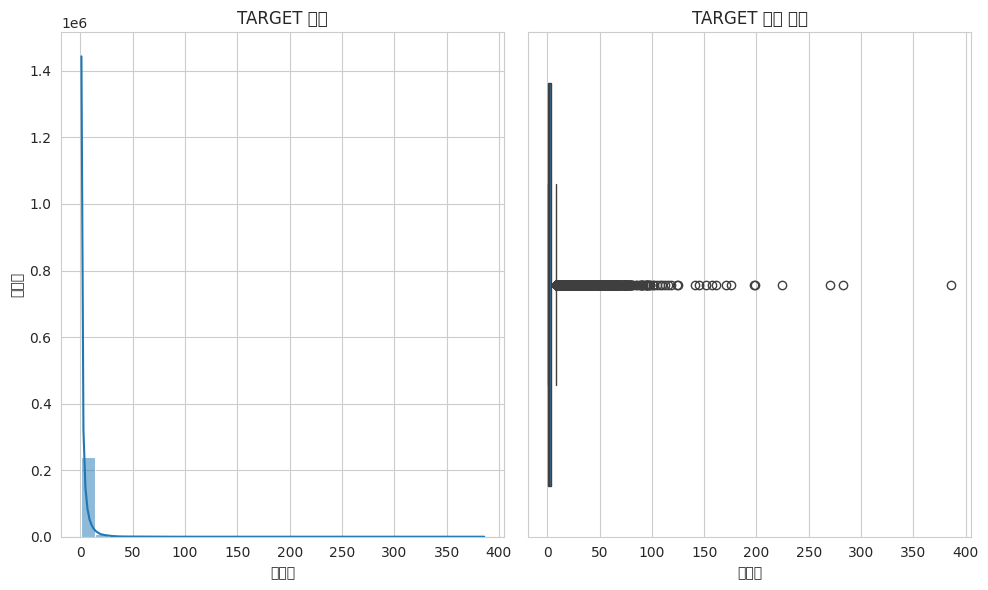

In [14]:
# Target 변수 시각화

# 스타일 설정
sns.set_style('whitegrid')

# 히스토그램과 박스 플롯 그리기 위한 subplot 생성
fig, ax = plt.subplots(1, 2, figsize=(10,6))

# 히스토 그램
sns.histplot(train['TARGET'], bins=30, ax=ax[0], kde=True)
ax[0].set_title('TARGET 분포')
ax[0].set_xlabel('조회수')
ax[0].set_ylabel('빈도수')

# 박스 플롯
sns.boxplot(x=train['TARGET'], ax=ax[1])
ax[1].set_title('TARGET 박스 플롯')
ax[1].set_xlabel('조회수')

plt.tight_layout()
plt.show()

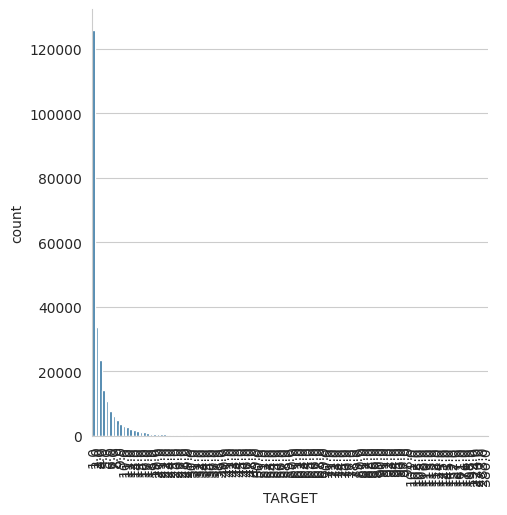

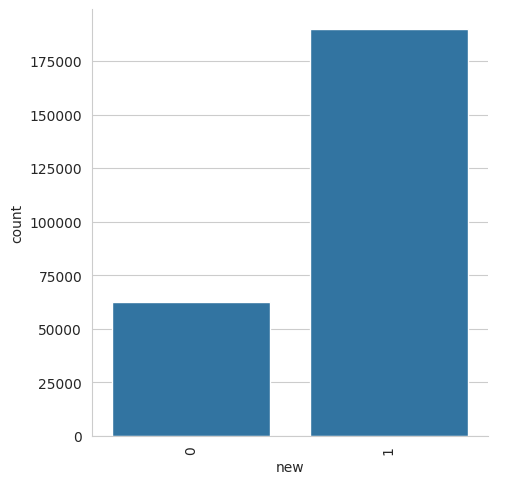

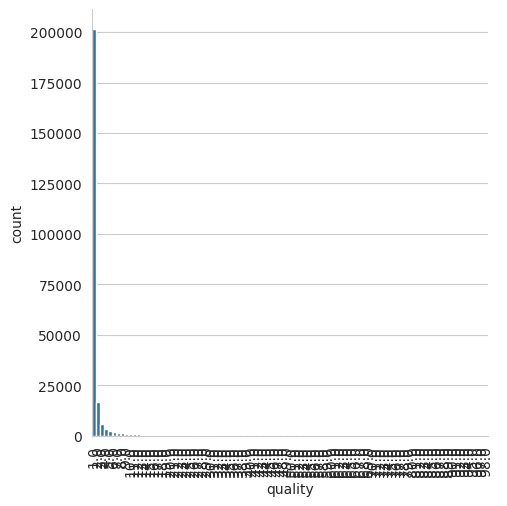

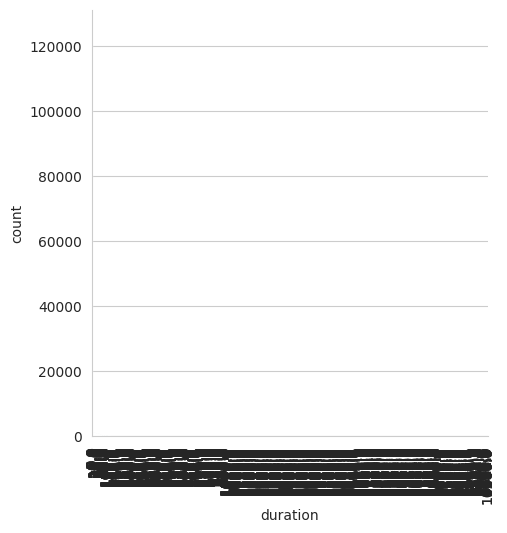

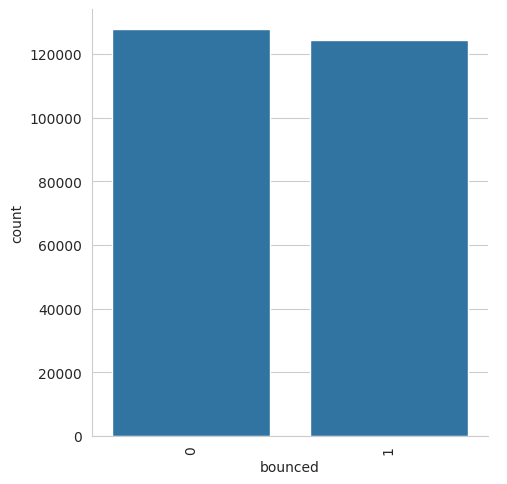

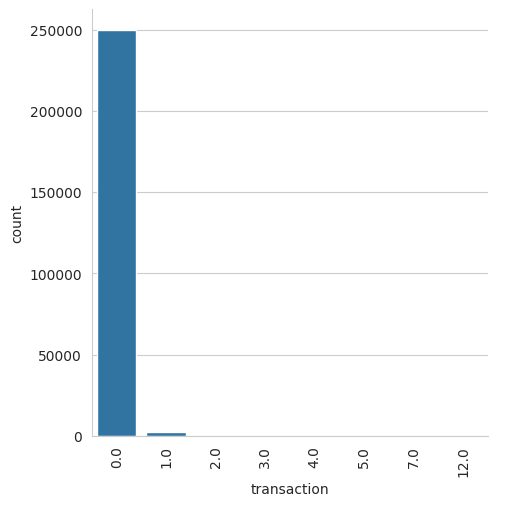

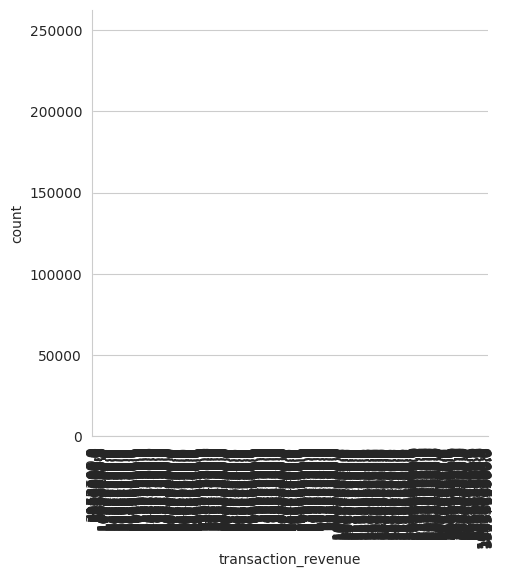

In [15]:
 # 숫자형 변수별 개수 시각화
for col in train.select_dtypes(include=['int','float']).columns:
  fig = sns.catplot(x=col, kind="count", data=train, hue=None)
  fig.set_xticklabels(rotation=90)
  plt.show()

<ipython-input-16-c114bb9a1f3d>:25: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  plt.tight_layout()
<ipython-input-16-c114bb9a1f3d>:25: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  plt.tight_layout()
<ipython-input-16-c114bb9a1f3d>:25: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  plt.tight_layout()
<ipython-input-16-c114bb9a1f3d>:25: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  plt.tight_layout()
<ipython-input-16-c114bb9a1f3d>:25: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  plt.tight_layout()
<ipython-input-16-c114bb9a1f3d>:25: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)

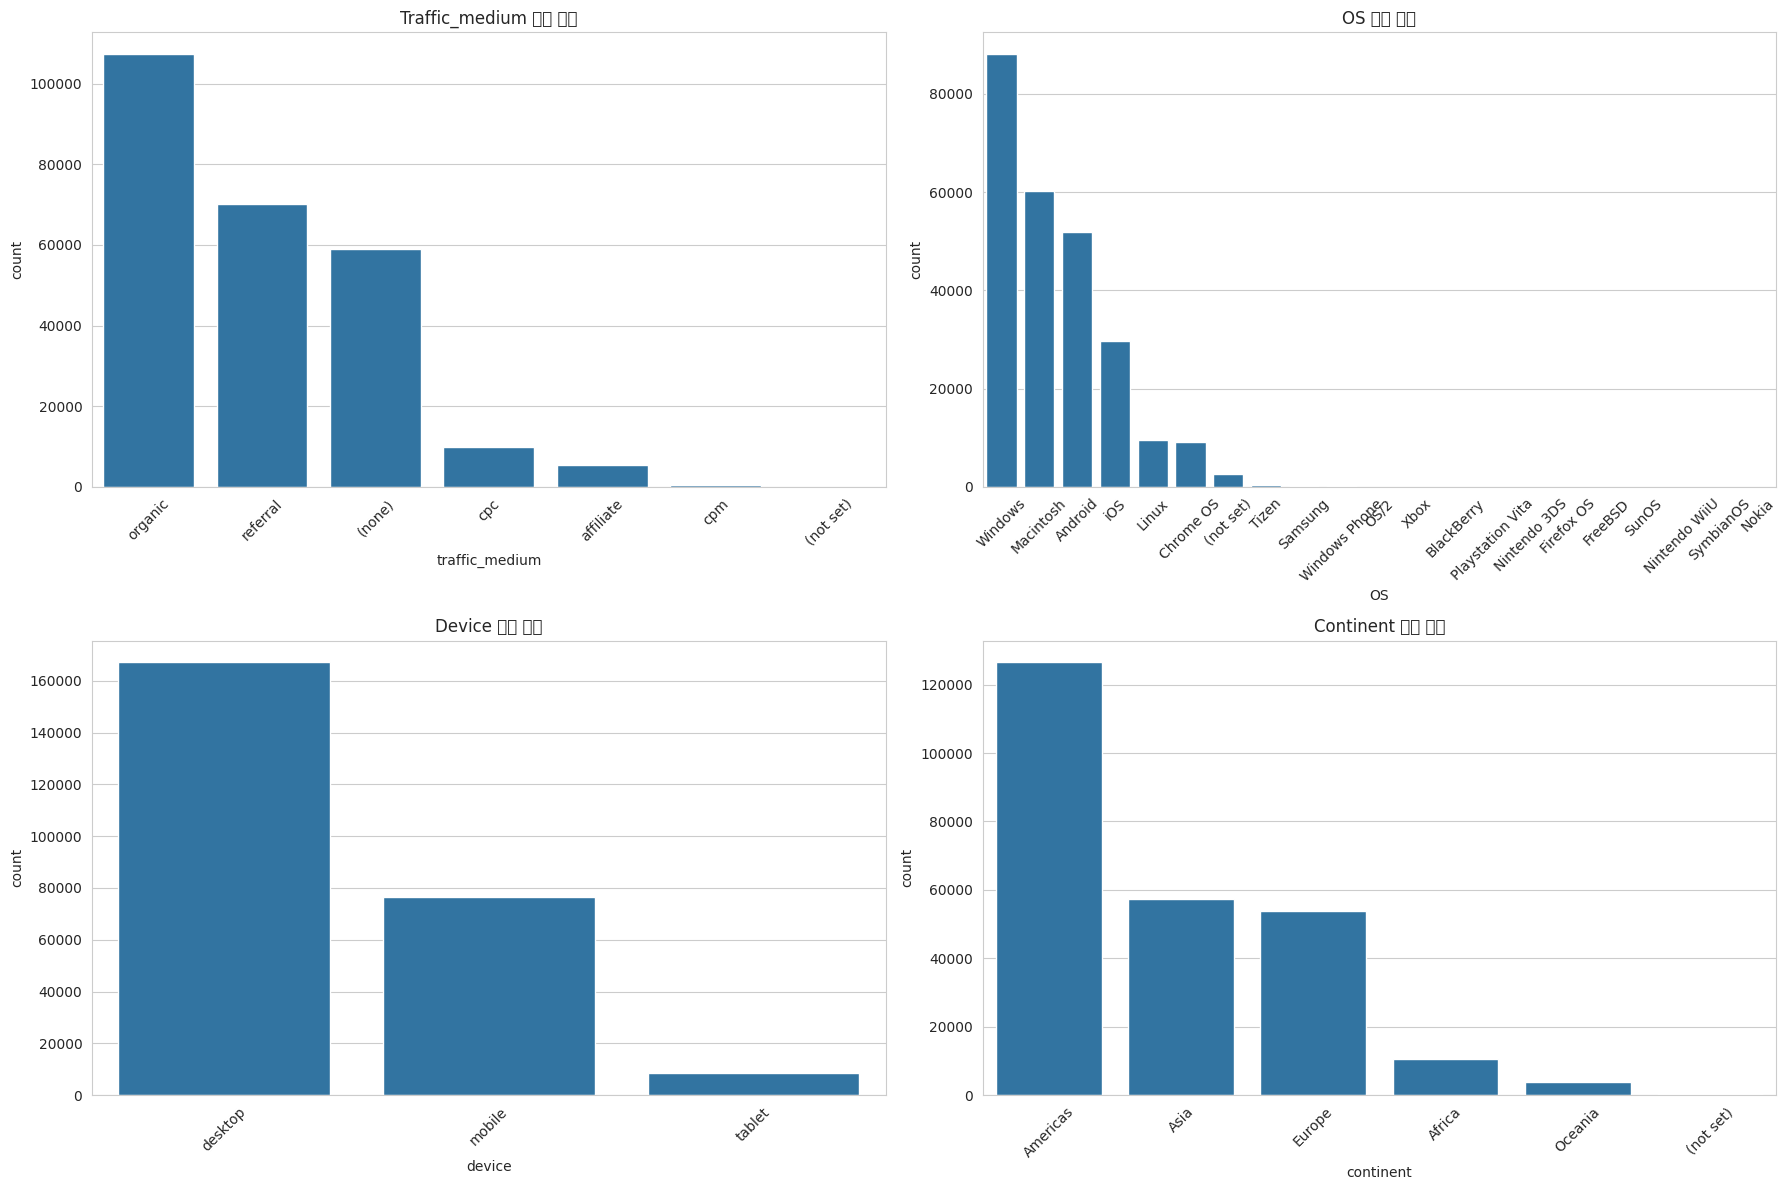

In [16]:
 # 범주형 변수별 개수 시각화

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# traffic_medium
sns.countplot(train, x='traffic_medium', ax=axes[0, 0], order=train['traffic_medium'].value_counts().index)
axes[0, 0].set_title('Traffic_medium 사용 분포')
axes[0, 0].tick_params(axis='x', rotation=45)

# OS
sns.countplot(train, x='OS', ax=axes[0, 1], order=train['OS'].value_counts().index)
axes[0, 1].set_title('OS 사용 분포')
axes[0, 1].tick_params(axis='x', rotation=45)

# device
sns.countplot(train, x='device', ax=axes[1, 0], order=train['device'].value_counts().index)
axes[1, 0].set_title('Device 사용 분포')
axes[1, 0].tick_params(axis='x', rotation=45)

# continent
sns.countplot(train, x='continent', ax=axes[1, 1], order=train['continent'].value_counts().index)
axes[1, 1].set_title('Continent 방문 분포')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 4. 결측치 처리

> NULL 값이 포함된 컬럼 찾기 -> NaN 값으로 채우기

keyword          137675
referral_path    161107
dtype: int64


<Axes: >

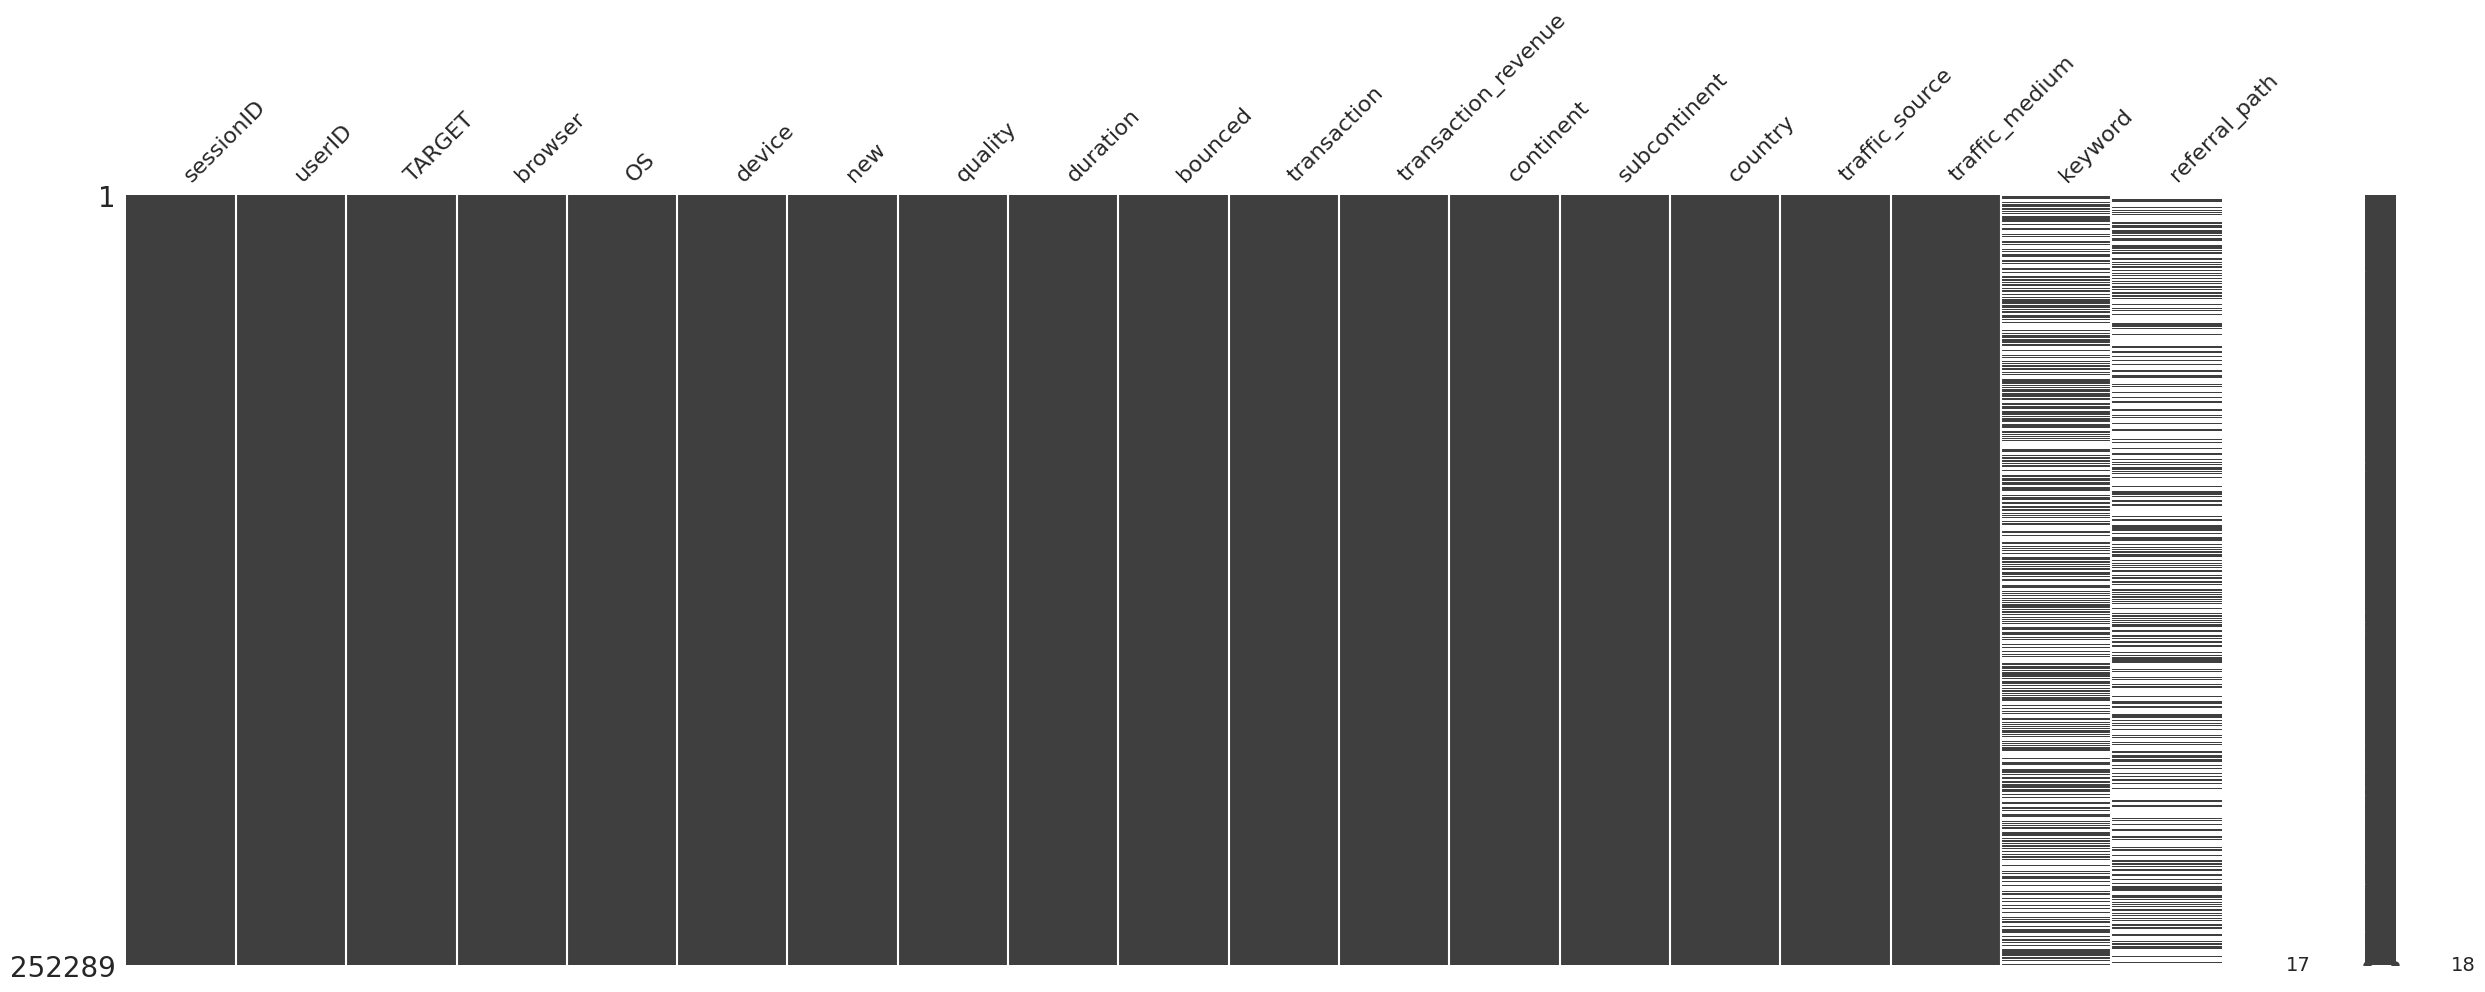

In [17]:
# 각 컬럼들에 몇 개의 NULL 값이 포함되어 있는지 확인

count_nan = train.isnull().sum()

print(count_nan[count_nan > 0])

# missingno 패키지를 통해 시각화 확인
missingno.matrix(train, figsize=(30,10))

<Axes: >

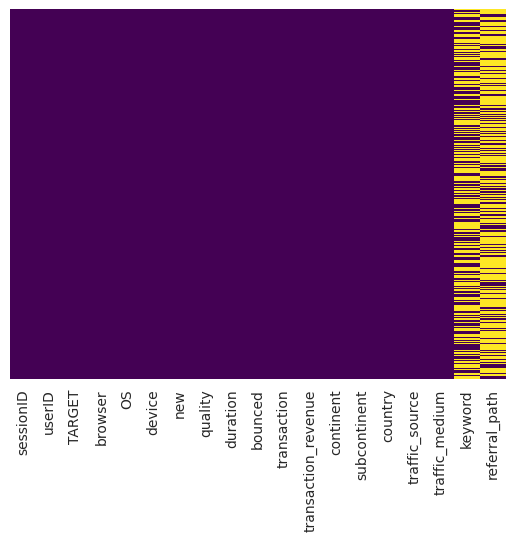

In [18]:
# seaborn 패키지 heatmap 을 통해 시각화 확인
sns.heatmap(train.isnull(), cbar=False, yticklabels=False, cmap='viridis')

<Axes: >

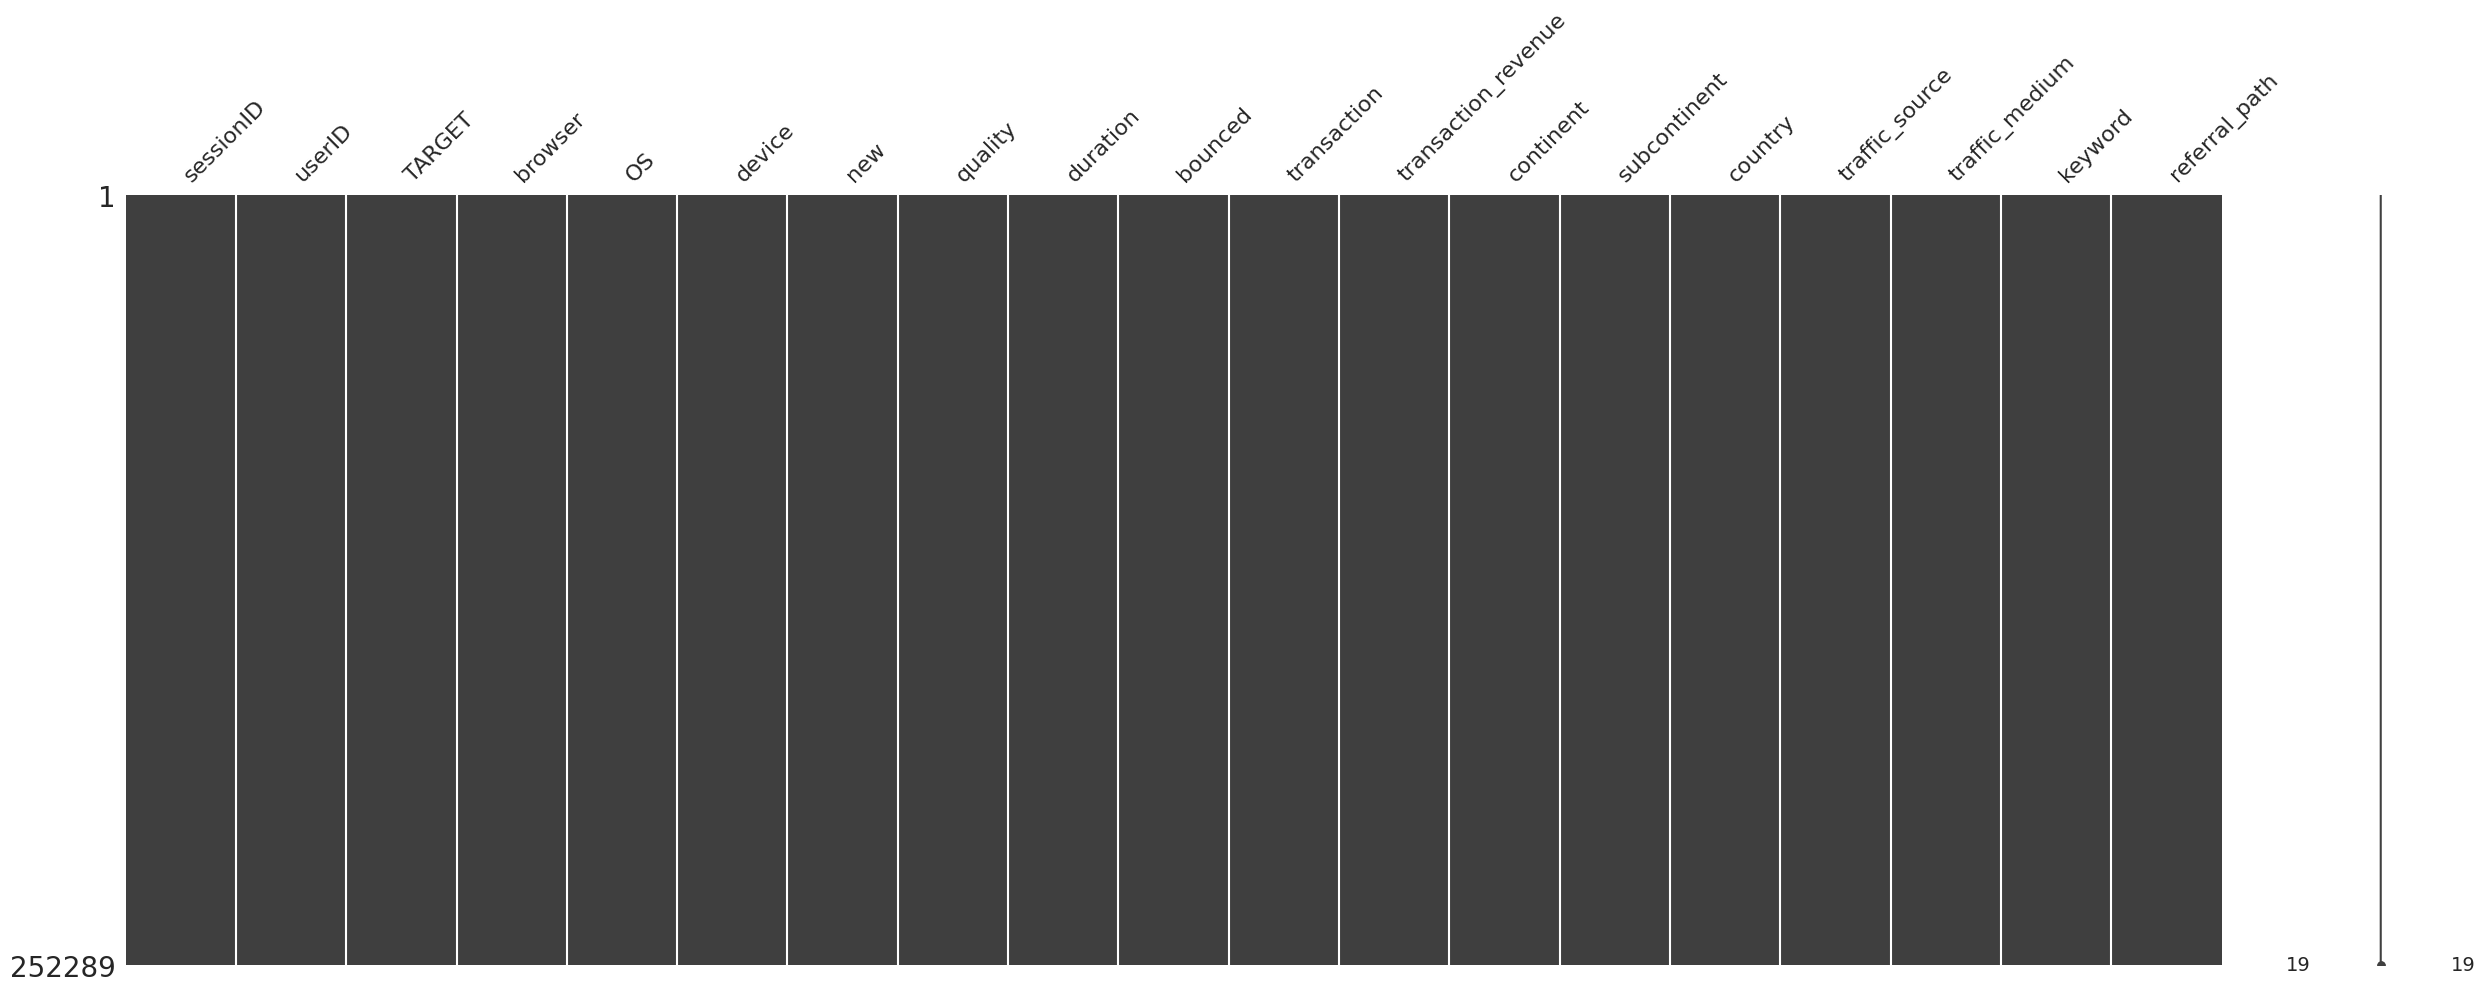

In [19]:
# NULL 값을 해당 컬럼의 NaN으로 대체하기
train_filled = train.copy()
train_filled['keyword'] = train_filled['keyword'].fillna('NaN')
train_filled['referral_path'] = train_filled['referral_path'].fillna('NaN')

# 확인
train_filled[['keyword', 'referral_path']].isnull().sum

# missingno 패키지를 통해 시각화 재확인
missingno.matrix(train_filled, figsize=(30,10))

### 5. 이상치 처리

> 숫자형 데이터별 요약 통계값 확인

In [20]:
# 데이터 컬럼별 요약 통계값 보기
display(train.describe().T)

,count,mean,std,min,25%,50%,75%,max
TARGET,252289.0,3.592626,5.509465e+00,1.0,1.0,2.0,4.0,3.860000e+02
new,252289.0,0.751955,4.318789e-01,0.0,1.0,1.0,1.0,1.000000e+00
quality,252289.0,3.816805,1.109103e+01,1.0,1.0,1.0,1.0,9.800000e+01
duration,252289.0,113.104253,3.308760e+02,0.0,0.0,3.0,71.0,1.118600e+04
bounced,252289.0,0.493672,4.999609e-01,0.0,0.0,0.0,1.0,1.000000e+00
transaction,252289.0,0.009033,1.009376e-01,0.0,0.0,0.0,0.0,1.200000e+01
transaction_revenue,252289.0,906124.829224,2.127689e+07,0.0,0.0,0.0,0.0,3.325712e+09


<Axes: ylabel='Frequency'>

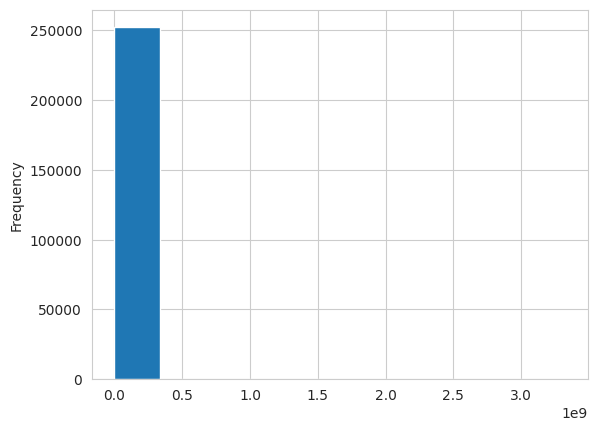

In [21]:
# 데이터 개별 컬럼 히스토그램으로 확인하기
train.transaction_revenue.plot.hist()

> 숫자형 데이터 Skewness 확인

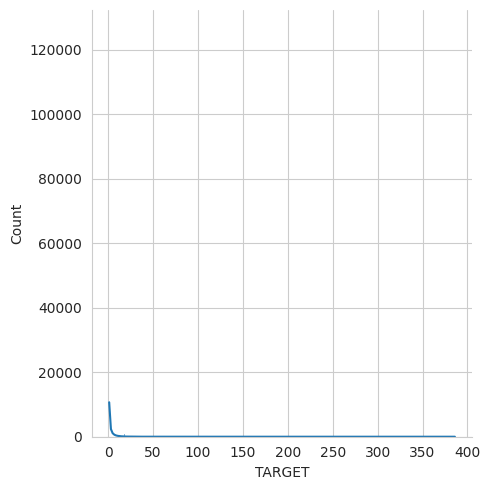

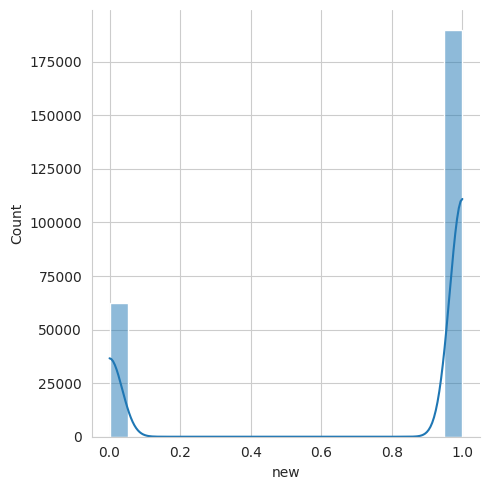

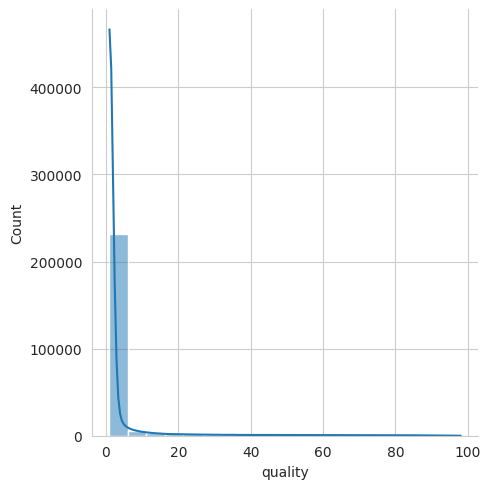

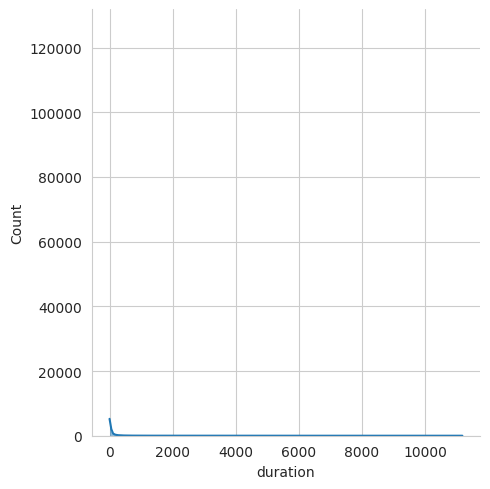

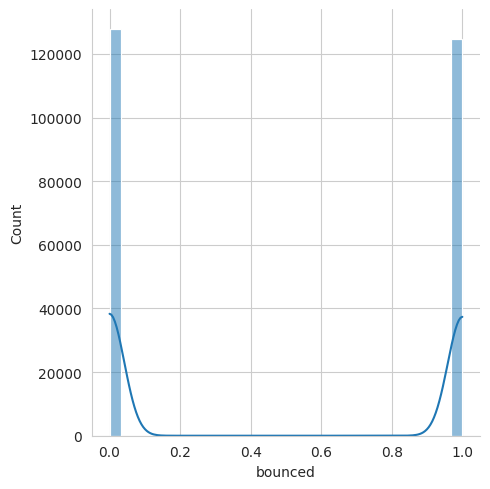

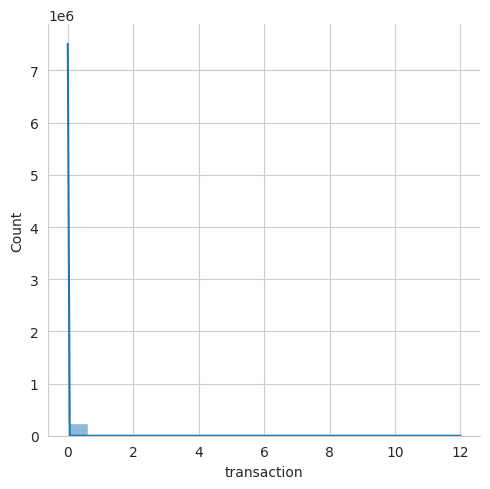

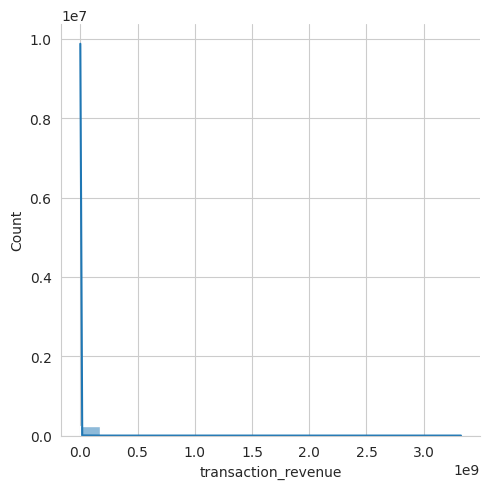

In [22]:
# 데이터 컬럼 타입이 np.number 인 것만 가져오기
numeric_data = train.select_dtypes(include=np.number)

# 데이터 컬럼 타입이 np.number 인 컬럼 이름들 가져오기
l = numeric_data.columns.values
number_of_columns = 7
number_of_rows = len(l)-1/number_of_columns

# 컬럼별 히스토그램 그리기
for i in range(0,len(l)):
  sns.displot(numeric_data[l[i]], kde=True)


> 숫자형 데이터 Box Plot 시각화

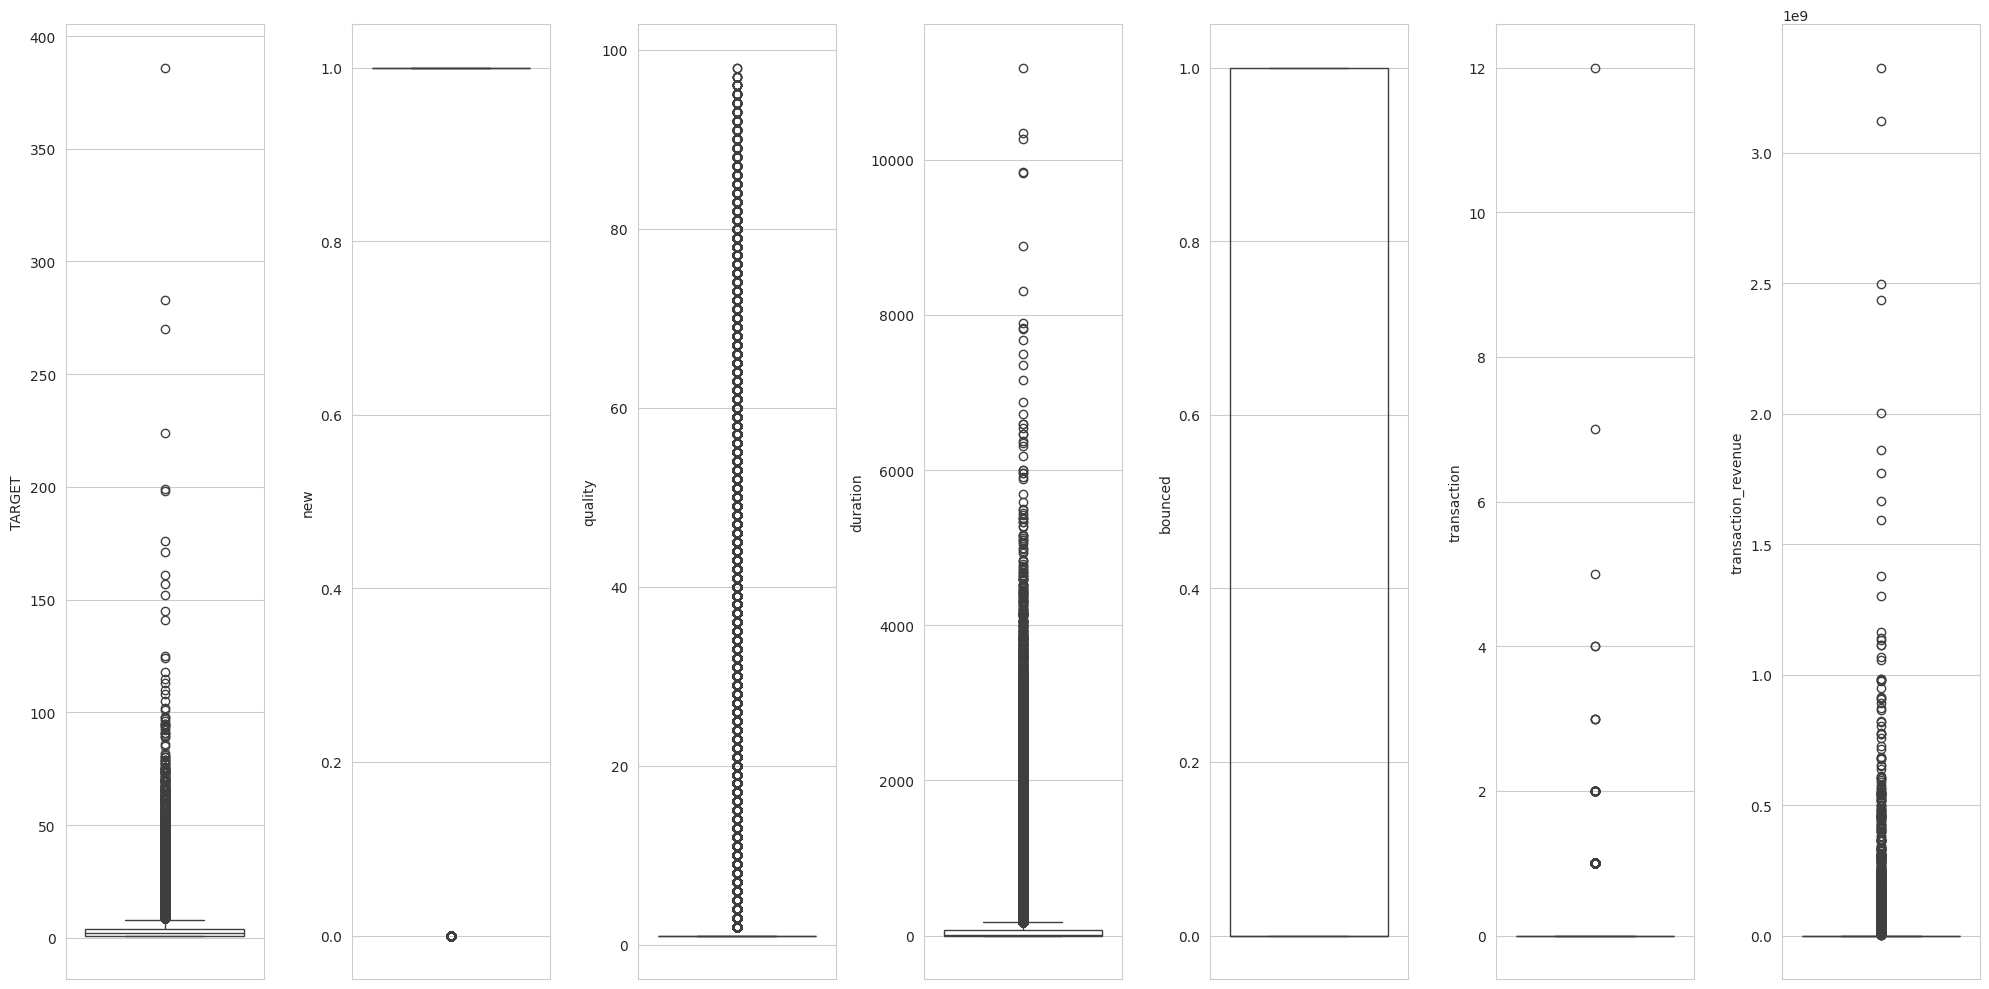

In [23]:
# 데이터 컬럼 타입이 np.number 인 컬럼들 가져오기
columns = train.select_dtypes(include=np.number).columns
figure = plt.figure(figsize=(20, 10))
figure.add_subplot(1, len(columns), 1)
for index, col in enumerate(columns):
    if index > 0:
        figure.add_subplot(1, len(columns), index + 1)
    sns.boxplot(y=col, data=train, boxprops={'facecolor': 'None'})
figure.tight_layout() # 자동으로 명시된 여백에 관련된 서브플롯 파라미터를 조정한다.
plt.show()

> 범주형 데이터별 Violin Plot 시각화

In [24]:
# if len(train.select_dtypes(include=['object','category']).columns) > 0:
#         for col_num in train.select_dtypes(include=np.number).columns:
#             for col in train.select_dtypes(include=['object','category']).columns:
#                 fig = sns.catplot(x=col, y=col_num, kind='violin', data=train, height=5, aspect=2)
#                 fig.set_xticklabels(rotation=90)
#                 plt.show()

### 6. 데이터 타입별 Feature 변환

#### 1) 범주형 Feature

In [25]:
cat_feat = train.select_dtypes('object','category').columns.values
train_cat = train[cat_feat].copy()
print(train_cat.nunique().sort_values())

device                 3
continent              6
traffic_medium         7
OS                    21
subcontinent          23
browser               70
traffic_source       168
country              205
keyword              623
referral_path       1578
userID            206024
sessionID         252289
dtype: int64


In [26]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

##### One-hot 인코딩

In [27]:
# One-hot 인코딩 대상 컬럼
onehot_columns = ['device', 'continent', 'traffic_medium']

# One-hot 인코딩
# One-hot 인코딩 수행
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(train_cat[onehot_columns])

# 데이터프레임 변환
onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


##### Binary 인코딩

In [28]:
# Binary 인코딩 대상 컬럼 (실제 Binary 인코딩을 위해 LabelEncoder를 먼저 사용하고, 이진수 변환을 수행)
binary_columns = ['browser', 'country', 'traffic_source', 'keyword', 'referral_path']

In [29]:
# Binary 인코딩 수행
label_encoder = LabelEncoder()
binary_encoded = np.array([label_encoder.fit_transform(train_cat[col]).astype(np.uint8) for col in binary_columns]).T
binary_encoded_nums = np.array([[int(np.binary_repr(val, width=32), 2) for val in col] for col in binary_encoded.T])

column_names = [f"feature_{i}_binary" for i in range(binary_encoded_nums.shape[1])]

# 데이터프레임 변환
binary_encoded_df = pd.DataFrame(binary_encoded_nums, columns=column_names)

##### Frequency 인코딩

In [30]:
# Frequency 인코딩 대상 컬럼
frequency_columns = ['OS', 'subcontinent']

In [31]:
# Frequency 인코딩 수행
frequency_encoded = train_cat[frequency_columns].apply(lambda x: x.map(x.value_counts(normalize=True)))

# 데이터프레임 변환
frequency_encoded_df = frequency_encoded

In [ ]:
# 모든 인코딩된 데이터 프레임을 하나로 병합
train_obj = pd.concat([onehot_encoded_df, binary_encoded_df, frequency_encoded_df], axis=1)

#### 2) 숫자형 Feature

In [ ]:
num_feat = train.select_dtypes('number').columns.values
train_num = train[num_feat].copy()

In [ ]:
print(train_num.nunique().sort_values())

In [ ]:
train.info()

In [ ]:
train_num = train_num.drop(['TARGET'],axis=1, errors='ignore')

### 7. 변수 간 상관성

> 숫자형 데이터 간 Pairwise 결합 분포 시각화

In [ ]:
# Seaborn Heatmap 을 사용한 Correlation 시각화
plt.figure(figsize=(6,4))
sns.heatmap(train.corr(), cmap='Blues', annot=False)

In [ ]:
sns.heatmap(train_obj.corr(), annot=True, cmap='Set1')

In [ ]:
sns.heatmap(train_num.corr(), annot=True, cmap='Set2')

In [ ]:
# 숫자 변수형 컬럼들 간 Pairplot 그리기
sns.pairplot(train.select_dtypes(include=np.number))
plt.show()

## 03. Regression 조회수 예측

### Training, Test 데이터 나누기

In [ ]:
# # 숫자형 데이터들만 copy()를 사용하여 복사
# X_num = train[['new','quality','duration','bounced','transaction']].copy()

# # 변환했던 범주형 데이터들과 concat을 사용하여 합치기
# X_final = pd.concat([X_num, OS_freq, device_freq, continent_freq, traffic_medium_freq ], axis=1)

# # 'TARGET' 컬럼을 y로, 나머지를 X로 분리
# y_final = train[['TARGET']].copy()

# # train_test_split을 사용하여 Training, Test 나누기
# X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=0)

# # 분할된 데이터의 형태 확인
# (X_train.shape, X_test.shape, y_train.shape, y_test.shape)